# Part 1

In [81]:
#Get data from Wikipedia table. Method by Syed Sadat Nazrul retrieved from 'Web Scraping HTML Tables with Python', Towards Data Science

import numpy as np
import requests
import lxml.html as lh
import pandas as pd
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
page = requests.get(url)
doc = lh.fromstring(page.content)
tr_elements = doc.xpath('//tr')
tr_elements = doc.xpath('//tr')
col=[]
i=0
for t in tr_elements[0]:
    i+=1
    name=t.text_content()
    col.append((name,[]))
for j in range(1,len(tr_elements)):
    T=tr_elements[j]
    
    if len(T)!=3:
        break
    
    i=0
    
    for t in T.iterchildren():
        data=t.text_content() 
        if i>0:
            try:
                data=int(data)
            except:
                pass
        col[i][1].append(data)
        i+=1
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)



In [82]:
#Drop rows where Borough is not assigned

df=df[df.Borough != 'Not assigned']

#Renaming reighbourhood column name because it had a "/" due to the extracting process

df.rename(columns={'Neighbourhood\n':'Neighbourhood'}, inplace=True)


In [83]:
#Join neighbourhoods when they share the postcode value

df2= pd.DataFrame(df.groupby(['Postcode','Borough'])['Neighbourhood'].apply(','.join).reset_index())


In [84]:
#Assign borough name to rows that have no neighbourhood value

df2['Neighbourhood2'] = np.where(df2['Neighbourhood']=='Not assigned\n',df2['Borough'],df2['Neighbourhood'])
df3=df2.drop(['Neighbourhood'], axis=1)
df3.rename(columns={'Neighbourhood2':'Neighbourhood'}, inplace=True)
df3.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge\n,Malvern\n"
1,M1C,Scarborough,"Highland Creek\n,Rouge Hill\n,Port Union\n"
2,M1E,Scarborough,"Guildwood\n,Morningside\n,West Hill\n"
3,M1G,Scarborough,Woburn\n
4,M1H,Scarborough,Cedarbrae\n


In [85]:
df3.shape

(103, 3)

# Part 2

In [86]:
#Add geo data to dataframe. Import csv

geo_data=pd.read_csv('https://cocl.us/Geospatial_data')
geo_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [87]:
pd.set_option('display.max_rows', 1000)
geo_data.rename(columns={'Postal Code':'Postcode'}, inplace=True)
df4 = pd.merge(left=geo_data,right=df3)
df4.head()

,Postcode,Latitude,Longitude,Borough,Neighbourhood
0,M1B,43.806686,-79.194353,Scarborough,"Rouge\n,Malvern\n"
1,M1C,43.784535,-79.160497,Scarborough,"Highland Creek\n,Rouge Hill\n,Port Union\n"
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood\n,Morningside\n,West Hill\n"
3,M1G,43.770992,-79.216917,Scarborough,Woburn\n
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae\n


In [88]:
df4.shape

(103, 5)

# Part 3 (Exploring)

In [89]:
#get Toronto latitude and longitude
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

Solving environment: done

# All requested packages already installed.

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [90]:
#Get Toronto map to visualize neighborhoods

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df4['Latitude'], df4['Longitude'], df4['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

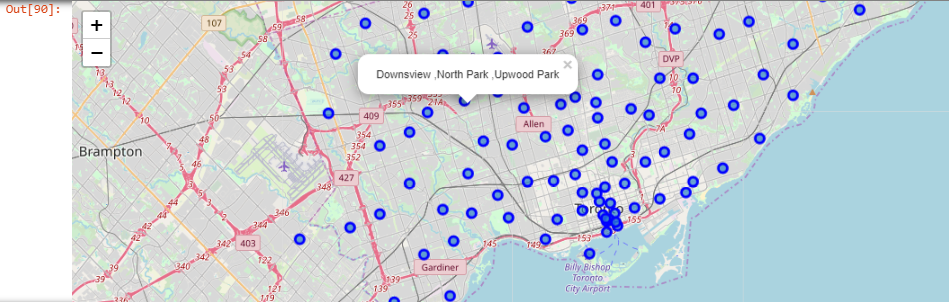

In [91]:
#Define credentials foursquare

CLIENT_ID = '3T1VHPU3JW1LHMID1FAIV0URXVVXLIEZTGUF5ZRCCGSNOJ0M' # your Foursquare ID
CLIENT_SECRET = 'NOX0XP04RFQL1PZHOZRCTSNOAO4UZINOU30IKDTTE0JOMLCJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 3T1VHPU3JW1LHMID1FAIV0URXVVXLIEZTGUF5ZRCCGSNOJ0M
CLIENT_SECRET:NOX0XP04RFQL1PZHOZRCTSNOAO4UZINOU30IKDTTE0JOMLCJ


In [92]:
#Exploring third neighborhood
neighborhood_latitude = df4.loc[3, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df4.loc[3, 'Longitude'] # neighborhood longitude value

neighborhood_name = df4.loc[3, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Woburn
 are 43.7709921, -79.21691740000001.


In [93]:
#Top 5 venues in third neigbourhood

LIMIT = 5 # limit of number of venues returned by Foursquare API

radius = 500 # define radius


url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()
results



{'meta': {'code': 200, 'requestId': '5d408b67d2495d0025addefa'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Toronto',
  'headerFullLocation': 'Toronto',
  'headerLocationGranularity': 'city',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': 43.7754921045, 'lng': -79.21069729639068},
   'sw': {'lat': 43.7664920955, 'lng': -79.22313750360935}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4cc1d28c06c254815ac18547',
       'name': 'Starbucks',
       'location': {'address': '300 Borough Dr',
        'crossStreet': 'Scarborough Town Centre',
        'lat': 43.770037201625215,
        'lng': -79.22115586641958,
        'labeledLatLngs':

In [94]:
# function that extracts the category of the venue

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

3 venues were returned by Foursquare.


In [95]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

toronto_venues = getNearbyVenues(names=df4['Neighbourhood'],
                                   latitudes=df4['Latitude'],
                                   longitudes=df4['Longitude']
                                  )
print(toronto_venues.shape)
toronto_venues.head()


(429, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge\n,Malvern\n",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek\n,Rouge Hill\n,Port Union\n",43.784535,-79.160497,RIGHT WAY TO GOLF,43.785177,-79.161108,Golf Course
2,"Highland Creek\n,Rouge Hill\n,Port Union\n",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood\n,Morningside\n,West Hill\n",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood\n,Morningside\n,West Hill\n",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [96]:
#Check unique categories

toronto_venues.groupby('Neighbourhood').count()
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 141 uniques categories.


In [97]:
# Analyze each neighbourhood

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Airport,Airport Food Court,Airport Lounge,Airport Terminal,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,...,Theme Restaurant,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wings Joint,Women's Store,Yoga Studio
0,"Rouge\n,Malvern\n",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Highland Creek\n,Rouge Hill\n,Port Union\n",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Highland Creek\n,Rouge Hill\n,Port Union\n",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Guildwood\n,Morningside\n,West Hill\n",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood\n,Morningside\n,West Hill\n",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
# Group neighbourhoods by boolean values

toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Airport,Airport Food Court,Airport Lounge,Airport Terminal,American Restaurant,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,...,Theme Restaurant,Toy / Game Store,Trail,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide\n,King\n,Richmond\n",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.2,0.0,0.0,0.0,0.0,0.0
1,Agincourt\n,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
2,"Agincourt North\n,L'Amoreaux East\n,Milliken\n...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
3,"Albion Gardens\n,Beaumond Heights\n,Humbergate...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
4,"Alderwood\n,Long Branch\n",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
5,"Bathurst Manor\n,Downsview North\n,Wilson Heig...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
6,Bayview Village\n,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
7,"Bedford Park\n,Lawrence Manor East\n",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0
8,Berczy Park\n,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.2,0.0,0.0,0.0,0.0,0.0
9,"Birch Cliff\n,Cliffside West\n",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,...,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
#Top 3 venues per neighbourhood

num_top_venues = 3

for hood in toronto_grouped['Neighbourhood']:
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    
#Load top 3 venues into dataframe

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,"Adelaide\n,King\n,Richmond\n",Concert Hall,Plaza,Steakhouse
1,Agincourt\n,Breakfast Spot,Skating Rink,Clothing Store
2,"Agincourt North\n,L'Amoreaux East\n,Milliken\n...",Playground,Park,Yoga Studio
3,"Albion Gardens\n,Beaumond Heights\n,Humbergate...",Pharmacy,Beer Store,Fried Chicken Joint
4,"Alderwood\n,Long Branch\n",Pizza Place,Pub,Coffee Shop


# Part 3 (Cluster)

In [100]:
# Clustering by 4 groups

from sklearn.cluster import KMeans

# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df4

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postcode,Latitude,Longitude,Borough,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,M1B,43.806686,-79.194353,Scarborough,"Rouge\n,Malvern\n",1.0,Fast Food Restaurant,Yoga Studio,Empanada Restaurant
1,M1C,43.784535,-79.160497,Scarborough,"Highland Creek\n,Rouge Hill\n,Port Union\n",1.0,Golf Course,Bar,Yoga Studio
2,M1E,43.763573,-79.188711,Scarborough,"Guildwood\n,Morningside\n,West Hill\n",1.0,Rental Car Location,Pizza Place,Electronics Store
3,M1G,43.770992,-79.216917,Scarborough,Woburn\n,2.0,Coffee Shop,Korean Restaurant,Yoga Studio
4,M1H,43.773136,-79.239476,Scarborough,Cedarbrae\n,1.0,Thai Restaurant,Bank,Hakka Restaurant


In [101]:
#Cluster map

import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

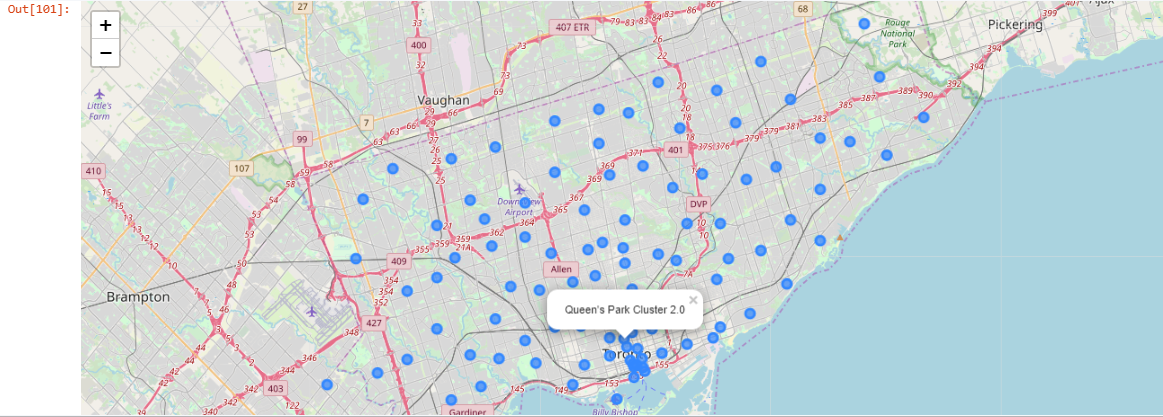